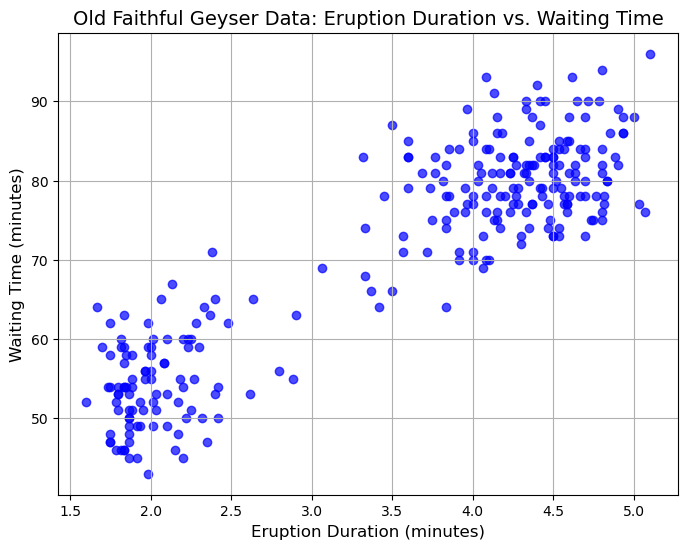

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset 
data = pd.read_excel('Old_Faithful_Geyser_Dataset.xlsx')

# Extract the feature vectors: "Eruption Duration" and "Waiting Time"
X = data[['Eruption Duration', 'Waiting Time']].values

# Plotting the data points in 2D
plt.figure(figsize=(8, 6))

# Scatter plot: X[:, 0] for Eruption Duration, X[:, 1] for Waiting Time
plt.scatter(X[:, 0], X[:, 1], color='blue', alpha=0.7)

# Labels and title
plt.title('Old Faithful Geyser Data: Eruption Duration vs. Waiting Time', fontsize=14)
plt.xlabel('Eruption Duration (minutes)', fontsize=12)
plt.ylabel('Waiting Time (minutes)', fontsize=12)

# Display grid
plt.grid(True)

# Save the plot as an image
plt.savefig('old_faithful_geyser_scatter.png')

# Show the plot
plt.show()

Converged at iteration 10
Final means: [[ 4.28966114 79.96810516]
 [ 2.03638752 54.47850696]]
Final covariances: [[[ 0.16996949  0.94062269]
  [ 0.94062269 36.0463619 ]]

 [[ 0.06916693  0.43515987]
  [ 0.43515987 33.69722921]]]
Final mixing coefficients: [0.64412753 0.35587247]


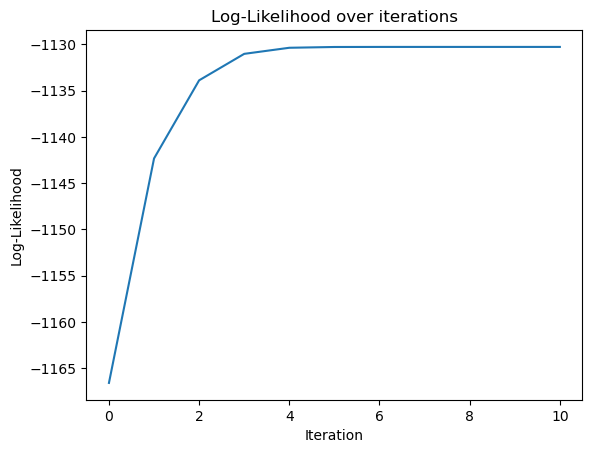

In [6]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Gaussian function for multivariate normal distribution
def gaussian_pdf(x, mean, cov):
    """
    Calculate the probability density function of a multivariate Gaussian.
    
    Parameters:
    - x: data point (n_features,)
    - mean: mean vector of the Gaussian (n_features,)
    - cov: covariance matrix of the Gaussian (n_features, n_features)
    
    Returns:
    - Probability density for the given data point.
    """
    d = x.shape[0]
    cov_inv = np.linalg.inv(cov)
    diff = x - mean
    exponent = -0.5 * np.dot(np.dot(diff.T, cov_inv), diff)
    return (1.0 / np.sqrt((2 * np.pi) ** d * np.linalg.det(cov))) * np.exp(exponent)

# Initialize EM parameters
def initialize_params(X, K):
    """
    Randomly initialize parameters for the Gaussian Mixture Model.
    
    Parameters:
    - X: Data points (n_samples, n_features)
    - K: Number of Gaussian components (clusters)
    
    Returns:
    - Initialized means, covariances, and mixture weights.
    """
    np.random.seed(42)  # For reproducibility
    n, d = X.shape
    
    # Initialize means from random points in the data
    mu = X[np.random.choice(n, K, replace=False)]
    
    # Initialize covariances as identity matrices
    sigma = np.array([np.eye(d) for _ in range(K)])
    
    # Initialize mixing coefficients uniformly
    phi = np.ones(K) / K
    
    return mu, sigma, phi

# E-step: calculate responsibilities (posterior probabilities)
def e_step(X, mu, sigma, phi, K):
    """
    E-step of the EM algorithm: compute the posterior probabilities (responsibilities).
    
    Parameters:
    - X: Data points (n_samples, n_features)
    - mu: Means of Gaussian components (K, n_features)
    - sigma: Covariance matrices (K, n_features, n_features)
    - phi: Mixing coefficients (K,)
    - K: Number of Gaussian components
    
    Returns:
    - Responsibilities matrix (n_samples, K)
    """
    n, d = X.shape
    gamma = np.zeros((n, K))
    
    for i in range(n):
        for k in range(K):
            gamma[i, k] = phi[k] * gaussian_pdf(X[i], mu[k], sigma[k])
        gamma[i, :] /= np.sum(gamma[i, :])  # Normalize to ensure sum of probabilities = 1
    
    return gamma

# M-step: update the parameters based on current responsibilities
def m_step(X, gamma, K):
    """
    M-step of the EM algorithm: update the parameters (mu, sigma, phi).
    
    Parameters:
    - X: Data points (n_samples, n_features)
    - gamma: Responsibilities (posterior probabilities), shape (n_samples, K)
    - K: Number of Gaussian components
    
    Returns:
    - Updated means, covariances, and mixing coefficients.
    """
    n, d = X.shape
    
    # Update means
    N_k = np.sum(gamma, axis=0)
    mu = np.dot(gamma.T, X) / N_k[:, None]
    
    # Update covariances
    sigma = np.zeros((K, d, d))
    for k in range(K):
        for i in range(n):
            diff = X[i] - mu[k]
            sigma[k] += gamma[i, k] * np.outer(diff, diff)
        sigma[k] /= N_k[k]
    
    # Update mixing coefficients
    phi = N_k / n
    
    return mu, sigma, phi

# Log-likelihood calculation
def log_likelihood(X, mu, sigma, phi, K):
    """
    Compute the log-likelihood of the current GMM model.
    
    Parameters:
    - X: Data points (n_samples, n_features)
    - mu: Means of Gaussian components (K, n_features)
    - sigma: Covariance matrices (K, n_features, n_features)
    - phi: Mixing coefficients (K,)
    - K: Number of Gaussian components
    
    Returns:
    - The log-likelihood value.
    """
    n, d = X.shape
    log_likelihood = 0
    
    for i in range(n):
        temp = 0
        for k in range(K):
            temp += phi[k] * gaussian_pdf(X[i], mu[k], sigma[k])
        log_likelihood += np.log(temp)
    
    return log_likelihood

# Complete EM algorithm
def em_algorithm(X, K, max_iters=100, tol=1e-6):
    """
    Full EM algorithm implementation to fit a Gaussian Mixture Model.
    
    Parameters:
    - X: Data points (n_samples, n_features)
    - K: Number of Gaussian components
    - max_iters: Maximum number of iterations
    - tol: Tolerance for convergence based on log-likelihood difference
    
    Returns:
    - Final parameters (mu, sigma, phi) and the log-likelihood values across iterations.
    """
    mu, sigma, phi = initialize_params(X, K)
    log_likelihoods = []
    
    for iteration in range(max_iters):
        # E-step: Compute responsibilities
        gamma = e_step(X, mu, sigma, phi, K)
        
        # M-step: Update parameters
        mu, sigma, phi = m_step(X, gamma, K)
        
        # Calculate log-likelihood
        log_likelihood_value = log_likelihood(X, mu, sigma, phi, K)
        log_likelihoods.append(log_likelihood_value)
        
        # Check for convergence
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return mu, sigma, phi, log_likelihoods

# Example usage
# Assuming X is your dataset, with each row as a 2-dimensional observation.
# For the Old Faithful Geyser Dataset, K = 2 (bimodal distribution)

K = 2  # Bimodal distribution

# Run the EM algorithm
mu, sigma, phi, log_likelihoods = em_algorithm(X, K)

# Print final parameters
print("Final means:", mu)
print("Final covariances:", sigma)
print("Final mixing coefficients:", phi)

# Plot log-likelihood over iterations
import matplotlib.pyplot as plt
plt.plot(log_likelihoods)
plt.title("Log-Likelihood over iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.savefig('scratch.png')
plt.show()

Converged at iteration 10


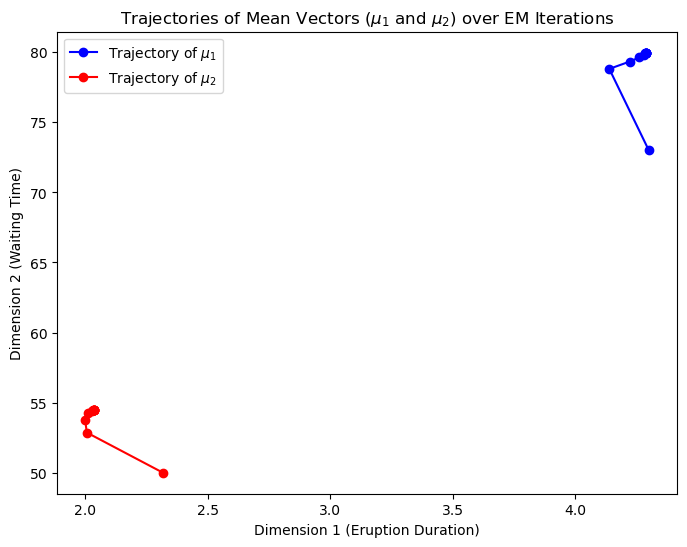

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def em_algorithm_with_mean_tracking(X, K, max_iters=100, tol=1e-6):
    """
    EM algorithm with mean tracking for plotting trajectories of mean vectors.
    
    Parameters:
    - X: Data points (n_samples, n_features)
    - K: Number of Gaussian components
    - max_iters: Maximum number of iterations
    - tol: Tolerance for convergence based on log-likelihood difference
    
    Returns:
    - Final parameters (mu, sigma, phi) and the log-likelihood values across iterations.
    - A list of mean vectors over the iterations.
    """
    mu, sigma, phi = initialize_params(X, K)
    log_likelihoods = []
    
    # List to store the trajectories of the mean vectors over iterations
    mean_trajectories = [mu.copy()]  
    
    for iteration in range(max_iters):
        # E-step: Compute responsibilities
        gamma = e_step(X, mu, sigma, phi, K)
        
        # M-step: Update parameters
        mu, sigma, phi = m_step(X, gamma, K)
        
        # Track the updated means after each iteration
        mean_trajectories.append(mu.copy())
        
        # Calculate log-likelihood
        log_likelihood_value = log_likelihood(X, mu, sigma, phi, K)
        log_likelihoods.append(log_likelihood_value)
        
        # Check for convergence: absolute difference in log-likelihood
        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return mu, sigma, phi, log_likelihoods, mean_trajectories

# Example usage
# Assuming X is your dataset, with each row as a 2-dimensional observation
K = 2  # Bimodal distribution

# Run the EM algorithm and track the means
mu, sigma, phi, log_likelihoods, mean_trajectories = em_algorithm_with_mean_tracking(X, K)

# Convert the list of mean trajectories to a NumPy array for easy plotting
mean_trajectories = np.array(mean_trajectories)  # shape will be (iterations, K, n_features)

# Plotting the trajectories of the two mean vectors
plt.figure(figsize=(8, 6))

# Plot trajectory for the first mean vector (mu_1)
plt.plot(mean_trajectories[:, 0, 0], mean_trajectories[:, 0, 1], 'o-', label='Trajectory of $\mu_1$', color='blue')

# Plot trajectory for the second mean vector (mu_2)
plt.plot(mean_trajectories[:, 1, 0], mean_trajectories[:, 1, 1], 'o-', label='Trajectory of $\mu_2$', color='red')

# Adding labels and title
plt.xlabel('Dimension 1 (Eruption Duration)')
plt.ylabel('Dimension 2 (Waiting Time)')
plt.title('Trajectories of Mean Vectors ($\mu_1$ and $\mu_2$) over EM Iterations')
plt.legend()
plt.savefig("mean_trajectories.png")
plt.show()

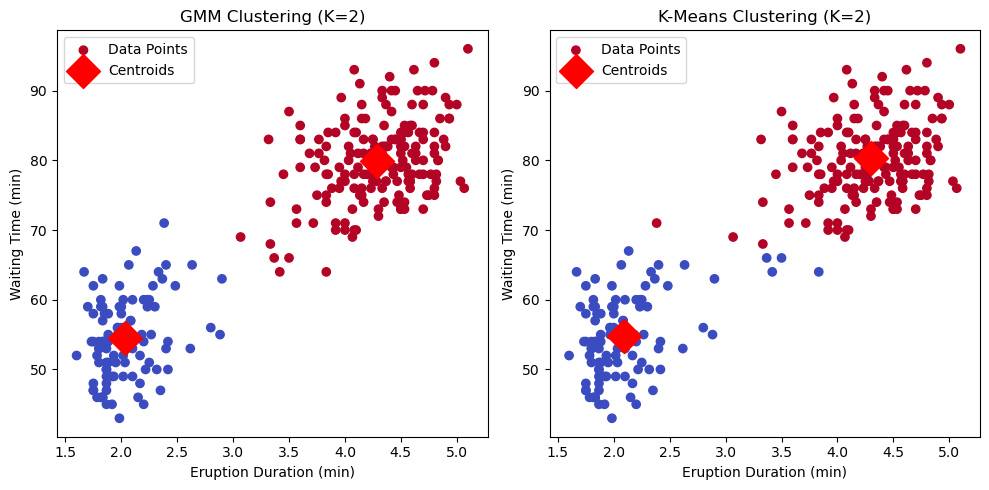

GMM Centroids:
 [[ 2.03652149 54.47986018]
 [ 4.28977944 79.96953298]]
KMeans Centroids:
 [[ 2.09433    54.75      ]
 [ 4.29793023 80.28488372]]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import mixture

# Use the same dataset 'X' from the previous problem

# Set up figure and axes for subplots
f, axes = plt.subplots(1, 2, figsize=(10, 5))
Ks = [2]  # We are using K = 2 for both algorithms

# Run GMM (EM algorithm) and plot
gmm_model = mixture.GaussianMixture(n_components=2, random_state=0)
gmm_model.fit(X)
gmm_labels = gmm_model.predict(X)
gmm_centroids = gmm_model.means_

axes[0].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='coolwarm', label='Data Points')
axes[0].scatter(gmm_centroids[:, 0], gmm_centroids[:, 1], s=300, c='red', marker='D', label='Centroids')
axes[0].set_title('GMM Clustering (K=2)')
axes[0].set_xlabel('Eruption Duration (min)')
axes[0].set_ylabel('Waiting Time (min)')
axes[0].legend()

# Run KMeans and plot
kmeans_model = KMeans(n_clusters=2, random_state=0)
kmeans_model.fit(X)
kmeans_labels = kmeans_model.labels_
kmeans_centroids = kmeans_model.cluster_centers_

axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='coolwarm', label='Data Points')
axes[1].scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], s=300, c='red', marker='D', label='Centroids')
axes[1].set_title('K-Means Clustering (K=2)')
axes[1].set_xlabel('Eruption Duration (min)')
axes[1].set_ylabel('Waiting Time (min)')
axes[1].legend()

plt.tight_layout()
plt.savefig("kmeans_vs_gmm")
plt.show()

# Print centroids for comparison
print("GMM Centroids:\n", gmm_centroids)
print("KMeans Centroids:\n", kmeans_centroids)